In [5]:
noExt=function(x){
return(tools::file_path_sans_ext(x))
}
bnoExt=function(x){
return(basename(tools::file_path_sans_ext(x)))
}
fNumber=function(x){
sapply(x,FUN=function(x){
strsplit(x,"__")[[1]][2]
})
}
rRider=function(x){
sapply(x,FUN=function(x){
strsplit(x,"-RIDER")[[1]][1]
})
}
# centering with 'scale()'
center_scale <- function(x) {
    scale(x, scale = FALSE)
}
#LOAD LIBRARIES 
library(gtools);
library("GenomicRanges");
options(warn=-1)
library(ggplot2)

In [6]:
#SETTING PATH 
pathGroseq="/sharedFolder/Data/3_gro_seq/bed/"
pathcutTagMet="/sharedFolder/Data/3_gro_seq/bed/"
previousResults="/sharedFolder/Results/Hotspot/"
results="/sharedFolder/Results/Sequencing/groSeq"
dir.create(results,recursive=TRUE)

In [7]:
dir.create(results,recursive=TRUE)
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")


In [5]:
gtf=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
gtf=gtf[grep("Ligase",gtf[,6]),]
a=list.files(pathGroseq,pattern=".bed",recursive=TRUE)
uu=grep("sorted",a)
if(length(uu)!=0){
a=a[-uu]
    }
a=mixedsort(a)
a2=sapply(a,FUN=function(x){strsplit(x,".bed")[[1]][1]})
groseq_count=matrix(0,ncol=length(unique(gtf[,7])),nrow=length(a2))
colnames(groseq_count)=sapply(unique(gtf[,7]),FUN=toString)
rownames(groseq_count)=a2
groseq_rpm=groseq_count
for(j in a){
    system(paste("echo",j))
temp=read.table(paste(pathGroseq,"/",j,sep=""),sep="\t")
tempGG=GRanges(seqnames=as.matrix(temp[,1]),ranges=IRanges(start = as.numeric(temp[,2]),end=as.numeric(temp[,3])),mcols=abs(as.numeric(temp[,4])))
    for(i in seq(nrow(gtf))){
        system(paste("echo",i/nrow(gtf)))
        gg=GRanges(seqnames=as.matrix(gtf[i,1]),ranges=IRanges(start = as.numeric(gtf[i,2]),end=as.numeric(gtf[i,3])))    
        over=findOverlaps(gg,tempGG)@to    
        name=as.vector(noExt((j)))
        groseq_count[name,toString(gtf[i,7])]= sum(tempGG[over]$mcols)
        groseq_rpm[name,toString(gtf[i,7])]= (sum(tempGG[over]$mcols)/sum(abs(temp[,4])))*1000000

   }

}
conditions=c("DMSO","Taze","Vale")
groseq_newcount=matrix(ncol=ncol(groseq_count))
groseq_newrpm=groseq_newcount
 for(i in conditions){
summa=t(as.matrix(colSums(groseq_count[grep(i,rownames(groseq_count)),])))
groseq_newcount=rbind(groseq_newcount,summa)
summa=t(as.matrix(colSums(groseq_rpm[grep(i,rownames(groseq_rpm)),])))
groseq_newrpm=rbind(groseq_newrpm,summa)

}
groseq_newrpm=groseq_newrpm[-1,]
groseq_newcount=groseq_newcount[-1,]
rownames(groseq_newrpm)=conditions
rownames(groseq_newcount)=conditions

write.table((t(groseq_newcount)),paste(results,"/groSeq_AID_Heatmap_count.csv",sep=""),col.names=NA,sep=",")
write.table((t(groseq_newrpm)),paste(results,"/groSeq_AID_Heatmap_RPM.csv",sep=""),col.names=NA,sep=",")


In [8]:
results

[1] "/sharedFolder/Results/Sequencing/groSeq"

[1] "RAW"
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 1.819488e-37 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 1.264686e-07 


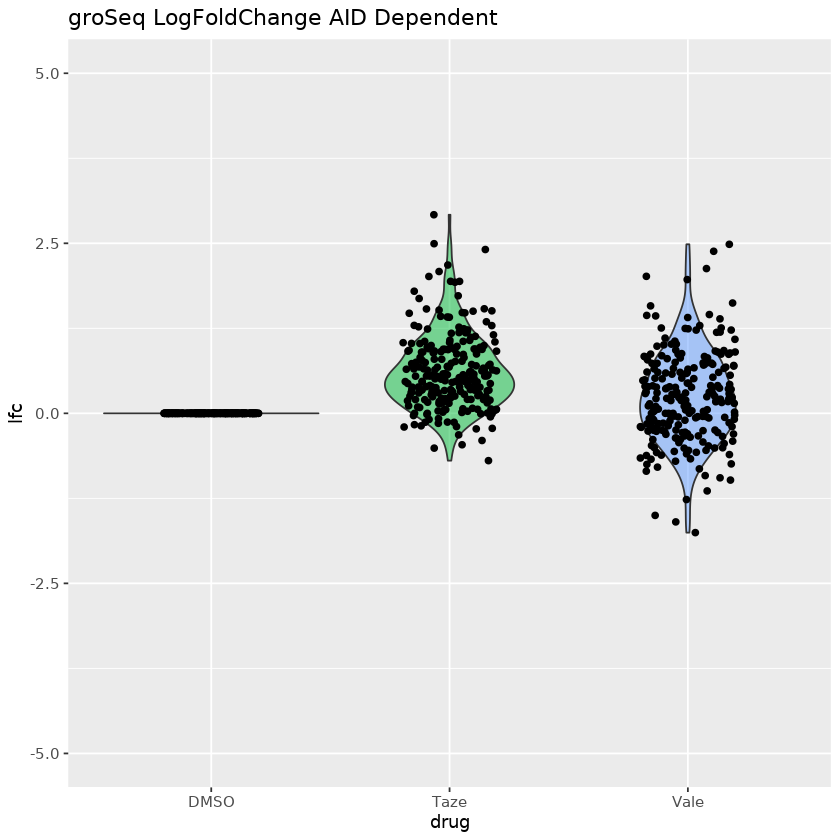

In [9]:
print("RAW")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/groSeq_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/Lig_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/Lig_DMSOTaze.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ylim(-5,5) + ggtitle("groSeq LogFoldChange AID Dependent")
plot(pp)   

condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

[1] "RAW Common "
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 8.277216e-24 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 1.239909e-06 


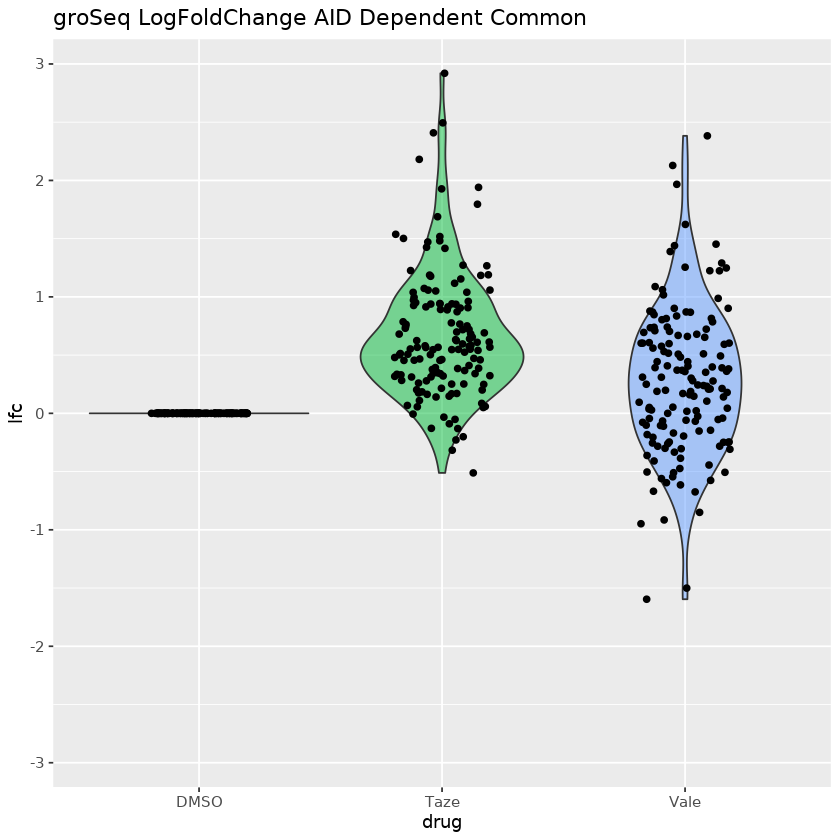

In [10]:
print("RAW Common ")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/groSeq_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_5_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_2_DMSO_TAZE.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ylim(-lim,lim) + ggtitle("groSeq LogFoldChange AID Dependent Common")
plot(pp)   

condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

[1] "filtered"
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 1.872281e-10 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 0.0002307313 


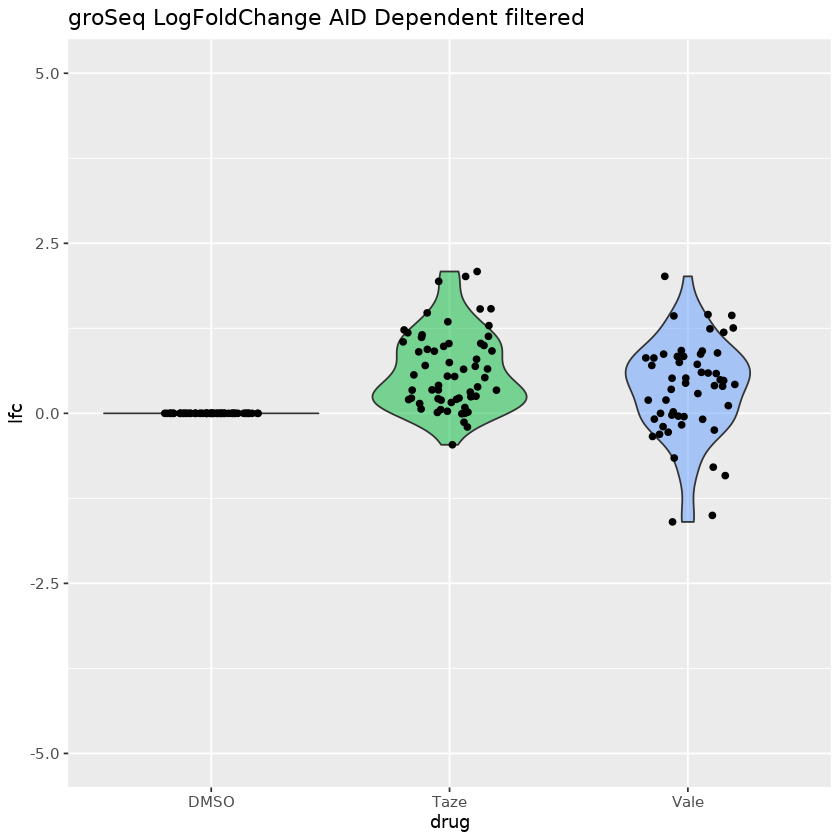

In [11]:
print("filtered")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/groSeq_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOTaze.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ylim(-5,5) + ggtitle("groSeq LogFoldChange AID Dependent filtered")
plot(pp)   

condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

In [12]:
data=as.matrix(read.table(paste(results,"/groSeq_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")


P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 6.713177e-10 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 0.01193078 


[1] "filtered Common"
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 5.960464e-06 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 0.07379258 


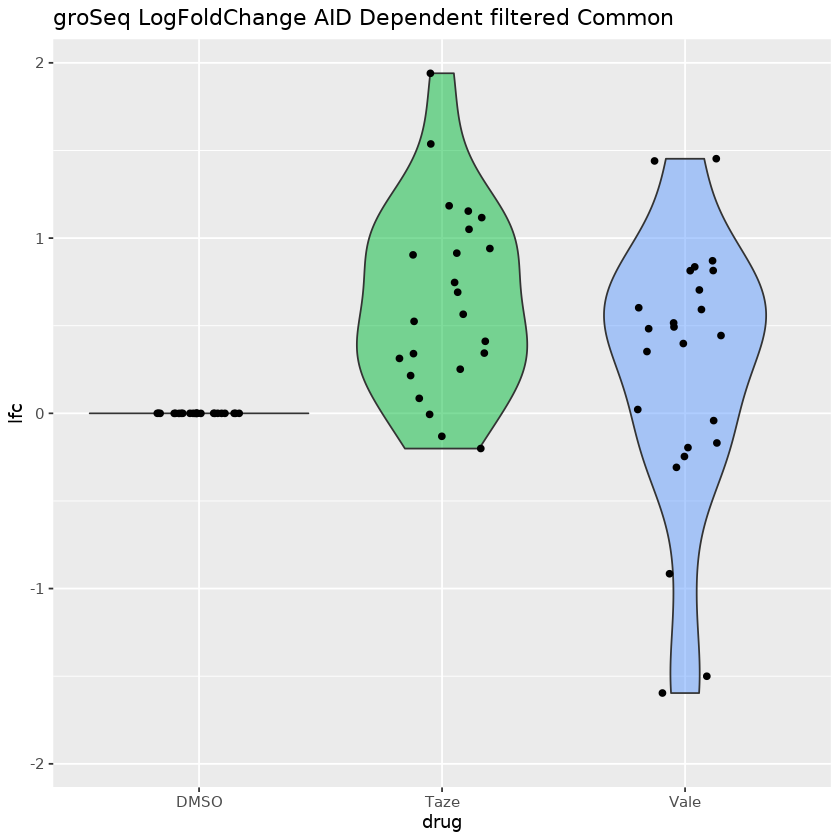

In [13]:
print("filtered Common")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/groSeq_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/sortNames/_5_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/sortNames/_2_DMSO_TAZE.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ylim(-lim,lim) + ggtitle("groSeq LogFoldChange AID Dependent filtered Common")
plot(pp)   

condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

In [2]:
# centering with 'scale()'
center_scale <- function(x) {
    scale(x, scale = FALSE)
}
library("pheatmap")
results="/sharedFolder/"
results2="/sharedFolder/Results/Sequencing/groSeq"
previousResults="/sharedFolder/Results/Hotspot/"
library("ggVennDiagram");
library("ggplot2")
library("vioplot")
library(eulerr)
f="TazeFiltered"#result name
cutTagMet_newrpm=as.matrix(read.table(paste(results2,"/groSeq_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))


In [3]:
Database=unique(read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")[,c(1,2,3,7)])
Taze=rownames(cutTagMet_newrpm)[sort(log2((cutTagMet_newrpm[,2]/cutTagMet_newrpm[,1])),index.return=TRUE)$ix]

rownames(Database)=Database[,4]
DBTU=Database[Taze,]

rmarkdown=matrix(ncol=1)
rmarkdown=rbind(rmarkdown,"---")
rmarkdown=rbind(rmarkdown,'title: "Hotspots"')
rmarkdown=rbind(rmarkdown,"---")
#write batch file 
batch=matrix(ncol=1)




for(i in seq(1,nrow(DBTU))){
temp=(DBTU[i,3]-DBTU[i,2])*2
batch=rbind(batch,paste("goto ",DBTU[i,1],":",(DBTU[i,2]-temp),"-",(DBTU[i,3]+temp),sep=""))
batch=rbind(batch,paste("snapshot ",i,".png",sep=""))


johnTemp=" "
    
rmarkdown=rbind(rmarkdown,paste("## ",rownames(DBTU)[i],sep=""))
rmarkdown=rbind(rmarkdown,paste("![",johnTemp,"](./",i,".png",")",sep=""))
rmarkdown=rbind(rmarkdown," ")

}
batch=batch[-1,]
write.table(batch,paste(results,"/",f,".batch",sep=""),col.names=FALSE,row.names=FALSE,sep="\t",quote=FALSE)
rmarkdown=rmarkdown[-1,]
write.table(rmarkdown,paste(results,"/",f,".rmd",sep=""),row.names=FALSE,col.names=FALSE,quote=FALSE)

In [4]:
f="ValeFiltered"#result name
Database=unique(read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")[,c(1,2,3,7)])
Taze=rownames(cutTagMet_newrpm)[sort(log2((cutTagMet_newrpm[,3]/cutTagMet_newrpm[,1])),index.return=TRUE)$ix]

rownames(Database)=Database[,4]
DBTU=Database[Taze,]

rmarkdown=matrix(ncol=1)
rmarkdown=rbind(rmarkdown,"---")
rmarkdown=rbind(rmarkdown,'title: "Hotspots"')
rmarkdown=rbind(rmarkdown,"---")
#write batch file 
batch=matrix(ncol=1)




for(i in seq(1,nrow(DBTU))){
temp=(DBTU[i,3]-DBTU[i,2])*2
batch=rbind(batch,paste("goto ",DBTU[i,1],":",(DBTU[i,2]-temp),"-",(DBTU[i,3]+temp),sep=""))
batch=rbind(batch,paste("snapshot ",i,".png",sep=""))


johnTemp=" "
    
rmarkdown=rbind(rmarkdown,paste("## ",rownames(DBTU)[i],sep=""))
rmarkdown=rbind(rmarkdown,paste("![",johnTemp,"](./",i,".png",")",sep=""))
rmarkdown=rbind(rmarkdown," ")

}
batch=batch[-1,]
write.table(batch,paste(results,"/",f,".batch",sep=""),col.names=FALSE,row.names=FALSE,sep="\t",quote=FALSE)
rmarkdown=rmarkdown[-1,]
write.table(rmarkdown,paste(results,"/",f,".rmd",sep=""),row.names=FALSE,col.names=FALSE,quote=FALSE)